## Image classification using LoRA

In [7]:
import sys
!{sys.executable} -m pip install -q transformers accelerate evaluate datasets peft torchvision


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.37.2
Accelerate version: 0.29.1
PEFT version: 0.10.0


In [2]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [3]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")
dataset

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

### Data preparation

In [4]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'baklava'

In [5]:
from transformers import AutoImageProcessor

## "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [8]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

In [9]:
image_processor.image_mean, image_processor.image_std

([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

In [11]:


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [10]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [12]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

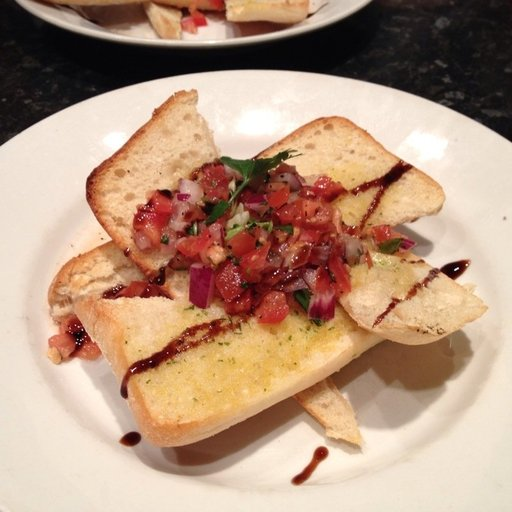

In [17]:
train_ds[0]["image"]

### Load and Prepare a model

In [22]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel() # Multiple hidden nodes at each layer counted
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
print_trainable_parameters(model)

trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


In [24]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 667493 || all params: 86543818 || trainable%: 0.77


## Trainer

In [ ]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

## Needs GPU
args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
    use_mps_device=True
)

### Evaluation Metrics

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [44]:
x_1d = list(torch.empty(3, 2))     # 3 lines

x_2d = torch.stack(x_1d)         # axis=0 stacking

x_3d = torch.stack(x_1d, 1)         # axis=1 stacking
x_2d, x_1d, x_3d

(tensor([[0., 0.],
         [0., 0.],
         [0., 0.]]),
 [tensor([0., 0.]), tensor([0., 0.]), tensor([0., 0.])],
 tensor([[0., 0., 0.],
         [0., 0., 0.]]))

In [63]:
train_ds[0]["pixel_values"].shape ## 224*224*224 #

torch.Size([3, 224, 224])

In [60]:
final = torch.stack([example["pixel_values"] for example in train_ds])
print(final.shape)
print(final[0])

torch.Size([4500, 3, 224, 224])
tensor([[[0.9373, 0.9294, 0.9529,  ..., 0.9059, 0.9059, 0.9137],
         [0.9451, 0.9373, 0.9529,  ..., 0.9216, 0.9059, 0.8980],
         [0.9451, 0.9373, 0.9529,  ..., 0.9216, 0.9059, 0.8902],
         ...,
         [0.5373, 0.5529, 0.5765,  ..., 0.9216, 0.9216, 0.9137],
         [0.6784, 0.6941, 0.7020,  ..., 0.9137, 0.9137, 0.9216],
         [0.7961, 0.8118, 0.8118,  ..., 0.9216, 0.9216, 0.9294]],

        [[0.8118, 0.8039, 0.8275,  ..., 0.7961, 0.7961, 0.8039],
         [0.8196, 0.8118, 0.8275,  ..., 0.8118, 0.7961, 0.7882],
         [0.8196, 0.8118, 0.8275,  ..., 0.8118, 0.7961, 0.7804],
         ...,
         [0.3882, 0.4039, 0.4275,  ..., 0.7961, 0.8039, 0.8118],
         [0.5294, 0.5451, 0.5529,  ..., 0.8039, 0.8118, 0.8118],
         [0.6471, 0.6627, 0.6627,  ..., 0.8118, 0.8196, 0.8196]],

        [[0.7098, 0.7020, 0.7255,  ..., 0.6941, 0.6941, 0.7020],
         [0.7176, 0.7098, 0.7255,  ..., 0.7098, 0.6941, 0.6863],
         [0.7176, 0.7098, 

In [68]:
print(train_ds[0]["label"])
final = torch.tensor([example["label"] for example in train_ds])
print(final.shape)
print(final[0])

10
torch.Size([4500])
tensor(10)


In [52]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples]) ## 224*224*224 # merge and stack batches
    labels = torch.tensor([example["label"] for example in examples]) # get a tensor list
    return {"pixel_values": pixel_values, "labels": labels}

In [69]:
collate_fn(train_ds)

{'pixel_values': tensor([[[[-0.8588, -0.8431, -0.8039,  ...,  0.9922,  1.0000,  1.0000],
           [-0.8745, -0.8745, -0.8588,  ...,  0.9922,  1.0000,  1.0000],
           [-0.8196, -0.8275, -0.8275,  ...,  0.9922,  1.0000,  1.0000],
           ...,
           [ 0.7176,  0.6392,  0.5137,  ...,  0.8510,  0.8275,  0.8667],
           [ 0.7412,  0.6627,  0.5216,  ...,  0.8353,  0.8118,  0.8588],
           [ 0.7725,  0.7020,  0.5608,  ...,  0.8196,  0.7961,  0.8275]],
 
          [[-0.8588, -0.8431, -0.8118,  ...,  0.9294,  0.9529,  0.9686],
           [-0.8745, -0.8824, -0.8667,  ...,  0.9373,  0.9529,  0.9608],
           [-0.8275, -0.8353, -0.8431,  ...,  0.9294,  0.9373,  0.9451],
           ...,
           [ 0.5216,  0.4510,  0.3176,  ...,  0.4667,  0.4510,  0.4902],
           [ 0.5451,  0.4745,  0.3255,  ...,  0.4510,  0.4353,  0.4824],
           [ 0.5765,  0.5059,  0.3647,  ...,  0.4353,  0.4118,  0.4510]],
 
          [[-0.8745, -0.8588, -0.8275,  ...,  0.8275,  0.8510,  0.8667

In [ ]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

In [ ]:
trainer.evaluate(val_ds)

### Load PEFT model

In [ ]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)

In [ ]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])
"Predicted class: beignets"